# Denoising-CNN

## 1. 构建通用类

In [1]:
import os
import time
import torch
from torch import nn
import torch.utils.data as td
from abc import ABC, abstractmethod

In [2]:
# 定义一个基本的基础的网络
class NeuralNetwork(nn.Module, ABC):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
    
    @property
    def device(self):
        return next(self.parameters()).device

    @abstractmethod
    def forward(self, x):
        pass
    @abstractmethod
    def criterion(self, voutput, vtarget):
        pass

In [3]:
# 定义一个管理网络中参数的管理器
class StatsManager(object):
    def __init__(self):
        self.init()
        
    def __repr__(self):
        return self.__class__.__name__
    
    def init(self):
        self.running_loss=0
        self.number_update=0
        
    def accumulate(self, loss, vinput=None, voutput=None, vtarget=None):
        self.running_loss+=loss
        self.number_update+=1
    
    def summarize(self):
        return self.running_loss/self.number_update

In [4]:
# 定义一个训练的类
class Experiment(object):
    def __init__(self, net, train_set, val_set, optimizer, stats_manager, 
                output_dir = None, batch_size = 16):
    
        # Define data Loaders
        # shuffle=True 在每个新的epoch里面会重新打乱形成新的batch
        # drop_last=True 当样本数量被分割成多个batch的时候，如果还有多的数据（少于batchsize），那么这些样本会被扔掉
        # pin_memory=True 让每个batch形成的张量能更快进入到cuda中
        self.train_loader = td.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
        self.val_loader = td.DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        # Define history
        self.history = []

        # Define checkpoint paths
        if output_dir is None:
            output_dir = "Denoising_{}".format(time.time())
        os.makedirs(output_dir, exist_ok=True)
        checkpoint_path = os.path.join(output_dir, "checkpoint.pth.tar")
        config_path = os.path.join(output_dir, "config.txt")

        # 将全局变量全部转化成字典形式
        maps = {k:v for k, v in locals().items() if k != 'self'}
        self.__dict__.update(maps)

        # 存储checkpoint或者继续加载模型
        if os.path.isfile(self.config_path):
            with open(config_path, 'r') as f:

                if (f.read()[:-1] != repr(self)):
                    raise ValueError(
                            "Cannot create this experiment: "
                            "I found a checkpoint conflicting with the current setting.")
                else:
                    self.load()
        else:
            self.save()
    
    # 获取当前的epoch
    @property
    def epoch(self):
        return len(self.history)
    
    # 获取当前的网络的配置，用字典返回
    def setting(self):
        return {'Net': self.net,
                'TrainSet': self.train_set,
                'ValSet': self.val_set,
                'Optimizer': self.optimizer,
                'StatsManager': self.stats_manager,
                'BatchSize': self.batch_size}   
    
    # 重写repr内置函数，用字符串的形式返回当前网络的配置
    def __repr__(self):
        string = ''
        for k, v in self.setting().items():
            if(k == 'TrainSet' or k == 'ValSet'):
                v = "Size is " + str(len(v))
            string += '{} : {} \n'.format(k, v)
        return string
    
    # 返回当前网络训练的状态，用字典的形式
    def state_dict(self):
        return {'Net': self.net.state_dict(),
                'Optimizer': self.optimizer.state_dict(),
                'History': self.history}
        
        
    # 将网络模型(重写的repr返回值)保存在config_path中，同时将网络的state_dict（参数什么的）保存到checkpoint_path
    def save(self):
        torch.save(self.state_dict(), self.checkpoint_path)
        with open(self.config_path, 'w') as f:
            print(self, file=f)
    
    
    # 读取检查点，进行装载
    def load(self):
        checkpoint = torch.load(self.checkpoint_path, map_location=self.net.device)
        self.net.load_state_dict(checkpoint['Net'])
        self.optimizer.load_state_dict(checkpoint['Optimizer'])
        self.history = checkpoint['History']
#         for state in self.optimizer.state.values():
#             for k, v in state.items():
#                 if isinstance(v, torch.Tensor):
#                     state[k] = v.to(self.net.device)
        del checkpoint
        
        
    def run(self, num_epochs, plot=None):
        # 设置网络的状态是train状态(mode=True)，而不是eval状态(mode=False)，这只对某些特定的模块有作用
        self.net.train(mode=True)
        self.stats_manager.init()
        start_epoch = self.epoch
        print("Start/Continue training from epoch {}".format(start_epoch))
        
#         if(plot is not None):
#             plot(self)
        
        for epoch in range(start_epoch, num_epochs):
            s = time.time()
            # 每一个新的epoch都要重新计算loss
            self.stats_manager.init()
            for vinput, vtarget in self.train_loader:
                # 将变量挂载到CPU或者GPU
                vinput = vinput.to(self.net.device)
                vtarget = vtarget.to(self.net.device)
                # 将优化器里面的梯度全部清空
                self.optimizer.zero_grad()
                # 开始前向传播
                voutput = self.net.forward(vinput)
                # 计算loss
                loss = self.net.criterion(voutput, vtarget)
                # 根据loss计算梯度
                loss.backward()
                # 利用优化器进行单次权值w更新
                self.optimizer.step()
                
                # loss.item()是将loss这个零维张量转化成浮点数
                with torch.no_grad():
                    self.stats_manager.accumulate(loss.item(), vinput, voutput, vtarget)
            # 将每次epoch中的loss加入到history中    
            self.history.append(self.stats_manager.summarize())
            # 输出每一轮的loss
            print('Epoch {}  Time:{}  Loss:{}'.format(self.epoch, time.time()-s, self.stats_manager.summarize()))
            # 每一个epoch后都对模型和训练过程进行保存
            self.save()
            if plot is not None:
                plot(self)
                
        print("Finish training for {} epochs".format(num_epochs))
            
    
    def evaluate(self):
        self.stats_manager.init()
        # 指定是eval模式
        self.net.eval()
        with torch.no_grad():
            for vinput, vtarget in self.val_loader:
                vinput = vinput.to(self.net.device)
                vtarget = vtarget.to(self.net.device)
                voutput = self.net.forward(vinput)
                loss = self.net.criterion(voutput, vtarget)
                self.stats_manager.accumulate(loss.item(), vinput, voutput, vtarget)
        return self.stats_manager.summarize()

In [5]:
# 设置跑网络的设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## 2. 准备数据集

In [6]:
%matplotlib inline
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import maxabs_scale, MaxAbsScaler
import copy

制造训练集相关类

In [7]:
# 对训练集和测试集进行预处理
class GetTraindata:
    def __init__(self, path):
        clean_filenames = [filename for filename in os.listdir(os.path.join(path, '干净信号txt')) if os.path.isfile(os.path.join(path, '干净信号txt', filename))]
        noisy_filenames = [filename for filename in os.listdir(os.path.join(path, '带噪信号txt')) if os.path.isfile(os.path.join(path, '带噪信号txt', filename))]
        clean_filenames.sort(key = lambda x:int(x[:-4]))
        noisy_filenames.sort(key = lambda x:int(x[:-4]))
        
        clean_signal = []
        noisy_signal = []
        for file_name in clean_filenames:
            clean_signal.append(np.loadtxt(os.path.join(path, '干净信号txt', file_name)))
        for file_name in noisy_filenames:
            noisy_signal.append(np.loadtxt(os.path.join(path, '带噪信号txt', file_name)))
        
        clean_signal = np.array(clean_signal)
        noisy_signal = np.array(noisy_signal)
        
#         进行归一化处理， fit_transforn进行计算数据集固有属性（fit），同时进行转化， tranform在已经计算好的fit上进行转化， invers_tainsform()将数据集转化回来
#         self.max_abs_scaler = MaxAbsScaler()
#         data = np.concatenate((clean_signal,noisy_signal),axis=0)
#         self.max_abs_scaler.fit(data)
#         clean_signal = self.max_abs_scaler.transform(clean_signal)
#         noisy_signal = self.max_abs_scaler.transform(noisy_signal)
        
        
        
#         clean_signal = maxabs_scale(clean_signal, axis=1)
#         noisy_signal = maxabs_scale(noisy_signal)
        
        # 将一维信号转化成[通道数， 长， 宽]格式
        self.clean_signal = clean_signal[:, np.newaxis, :]
        self.noisy_signal = noisy_signal[:, np.newaxis, :]
        
#     def get_scaler(self):
#         return self.max_abs_scaler
    
    def get_data(self):
        return self.clean_signal, self.noisy_signal
    
#     def get_origin_data(self):
#         clean_orgin_signal = self.max_abs_scaler.inverse_transform(clean_signal)
#         noisy_orgin_signal = self.max_abs_scaler.inverse_transform(noisy_signal)

In [8]:
# 将数据装载到clean当中, data为数据集合， 为eval模式下的数据数量:总数据量/num
class GetDataset(Dataset):
    def __init__(self, data, num):
        self.mode = ""   # train模式使用train数据， eval模式使用eval数据
        self.eval_clean_signal = []
        self.train_clean_signal = []
        self.eval_noisy_signal = []
        self.train_noisy_signal = []
        clean_signal = data[0]
        noisy_signal = data[1]
        # 构造训练集和测试集
        count = 0
        for i in clean_signal:
            count += 1
            if(count%num == 0 or count >= 503):
#            if((count > 500 and count < 1000) or (count > 3000 and count < 4000)):
                self.eval_clean_signal.append(i)
            else:
                self.train_clean_signal.append(i)
        
        count = 0
        for i in noisy_signal:
            count += 1
            if(count%num == 0 or count >= 503):
 #           if((count > 500 and count < 1000) or (count > 3000 and count < 4000)):
                self.eval_noisy_signal.append(i)
            else:
                self.train_noisy_signal.append(i)    
        

                
    
    # 返回的是一个2*1*2001   ([1, 2001], [1, 2001])
    def __getitem__(self, index):
        clean = []
        noisy = []
        if(self.mode == "train"):
            clean = self.train_clean_signal[index]
            noisy = self.train_noisy_signal[index]
        elif(self.mode == "eval"):
            clean = self.eval_clean_signal[index]
            noisy = self.eval_noisy_signal[index]
        
        #归一化，返回值为归一化后的数据 
        clean = maxabs_scale(clean, axis=1)
        noisy = maxabs_scale(noisy, axis=1)
        
        clean = torch.Tensor(clean)
        noisy = torch.Tensor(noisy)
        
        return noisy, clean
    
    def __len__(self):
        if(self.mode == "train"):
            return len(self.train_clean_signal)
        else:
            return len(self.eval_clean_signal)
            
    def train(self):
        self.mode = "train"
        self.eval_clean_signal = []
        self.eval_noisy_signal = []
        return self.mode
        
    def eval(self):
        self.mode = "eval"
        self.train_clean_signal = []
        self.train_noisy_signal = []
        return self.mode

导入数据集

In [9]:
dataset_path = "./dataset"

In [10]:
data = GetTraindata(dataset_path)
data_set = GetDataset(data.get_data(), 10)

train_set = copy.deepcopy(data_set)
train_set.train()

test_set = copy.deepcopy(data_set)
test_set.eval()

'eval'

In [11]:
len(test_set)

4568

In [12]:
train_set[0][1]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0004, 0.0004, 0.0002]])

In [13]:
# 设计一个我的画图
def mysignalshow(signal, ax = plt):
#     将归一化后的数据进行还原的信号
#    signal = data.max_abs_scaler.inverse_transform(signal.to('cpu').numpy())[0]
    # 转化成cpu
    signal = signal.to('cpu').numpy()[0]
    ax.plot(signal)

看下测试集图像

In [14]:
# for i in range(len(test_set)):
#     plt.clf()
#     mysignalshow(test_set[i][1])
#     plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\测试集图形\{}.svg'.format(i))

In [15]:
# for i in range(len(train_set)):
#     plt.clf()
#     mysignalshow(train_set[i][1])
#     plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\训练集图像\{}.svg'.format(i))

## 3. DnCNN

实现DnCNN的网络

In [16]:
class DnCNN(NeuralNetwork):
    def __init__(self, D , C=64):
        super(DnCNN, self).__init__()
        self.D = D
        self.mse = nn.MSELoss()
        # 用于保留最后一个batch中所有的特征
        self.features = []
        
        # 开始搭建卷积层
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv1d(1, C, 3, padding = 1))
        self.conv.extend([nn.Conv1d(C, C, 3, padding = 1) for _ in range(D)])
        self.conv.append(nn.Conv1d(C, 1, 3, padding = 1))
        
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv)):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        
        # 设置bn层
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm1d(C) for _ in range(D)])
        for i in range(len(self.bn)):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))
            
    def forward(self, vinput):
        self.features.clear()
        D = self.D
        h = F.leaky_relu(self.conv[0](vinput))
        self.features.append(h)
        for i in range(D):
            h = F.leaky_relu(self.bn[i](self.conv[i+1](h)))
            self.features.append(h)
        voutput = self.conv[D+1](h) + vinput
        return voutput
    
    # 损失函数使用均方误差
    def criterion(self, voutput, vtarget):
        return self.mse(voutput, vtarget)

随便跑一跑

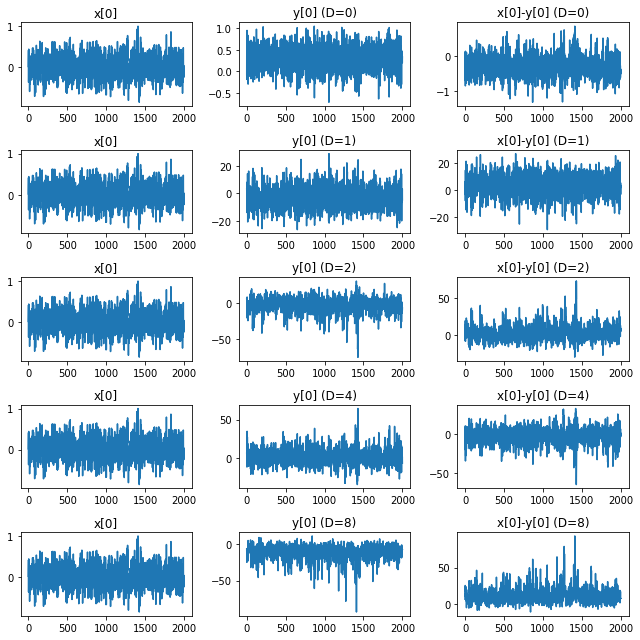

In [17]:
x,t = train_set[0]
# 给数据添加一个维度来代表batch-size
x = x.unsqueeze(0).to(device)
Dnum = [0, 1, 2, 4, 8]



fig, axes = plt.subplots(nrows=len(Dnum), ncols = 3, figsize=(9, 9))
for i in range(len(Dnum)):
    with torch.no_grad():
        model = DnCNN(Dnum[i]).to(device)
        y = model(x)

    mysignalshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    mysignalshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f'y[0] (D={Dnum[i]})')
    mysignalshow(x[0]-y[0], ax=axes[i][2])
    axes[i][2].set_title(f'x[0]-y[0] (D={Dnum[i]})')
#     mysignalshow(t, ax=axes[i][3])
#     axes[i][3].set_title(f'clean (D={Dnum[i]})')
    plt.tight_layout()



实现下DnCNN的StatsManager

In [18]:
class DenoisingStatsManager(StatsManager):
    def __init__(self):
        super(DenoisingStatsManager, self).__init__()
    
    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0
        
    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d) 
        n = x.shape[0] * x.shape[1] * x.shape[2] 
        self.running_psnr += 10*torch.log10(3*n/(torch.norm(y-d)**2))
        
    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.number_update
        return {'loss': loss, 'PSNR': psnr.cpu()}

In [19]:
def plot(exp, fig, axes, noisy, clean, visu_rate=2):
#     if(exp.epoch != 200):
#         return 
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[None].to(net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[0][2].clear()
    axes[1][0].clear()
    axes[1][1].clear()

    mysignalshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy signal')
    
    mysignalshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised signal')
    
    mysignalshow(clean, ax=axes[0][2])
    axes[0][2].set_title('Clean signal')
    
    axes[1][0].plot([exp.history[k]['loss'] for k in range(exp.epoch)], label='training loss')
    axes[1][0].set_ylabel('Loss')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].legend()
    
    axes[1][1].plot([exp.history[k]['PSNR'] for k in range(exp.epoch)], label='training psnr')
    axes[1][1].set_ylabel('PSNR')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].legend()
    
    plt.tight_layout()
    fig.canvas.draw()

DnCNN开始训练

In [20]:
lr = 1e-3
net = DnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp1 = Experiment(net, train_set, test_set, adam, stats_manager, batch_size=10, 
               output_dir="./checkpoints/denoising1")

Start/Continue training from epoch 200
Finish training for 200 epochs


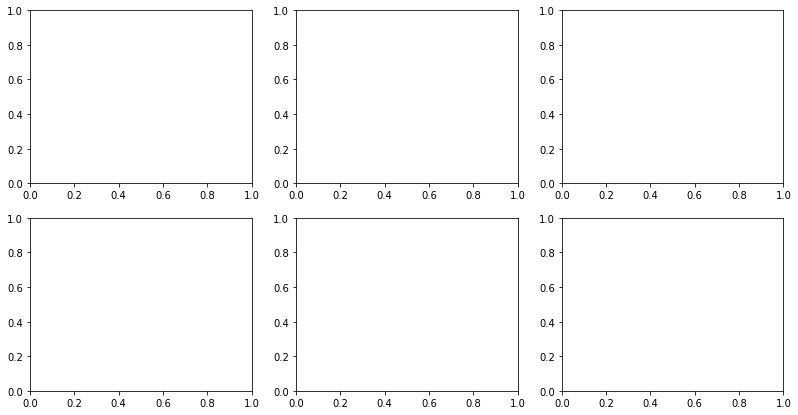

In [21]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13.5, 7))
exp1.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[11][0], clean=test_set[11][1]))
os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR', exist_ok=True)
plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR\{}.svg'.format("DnCNN_PSNR"))

## 4. UDnCNN

In [22]:
class UDnCNN(NeuralNetwork):
    def __init__(self, D , C=64):
        super(UDnCNN, self).__init__()
        self.D = D
        self.mse = nn.MSELoss()
        self.features = []
        
        # 开始搭建卷积层
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv1d(1, C, 3, padding = 1))
        self.conv.extend([nn.Conv1d(C, C, 3, padding = 1) for _ in range(D)])
        self.conv.append(nn.Conv1d(C, 1, 3, padding = 1))
        
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv)):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        
        # 设置bn层
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm1d(C) for _ in range(D)])
        for i in range(len(self.bn)):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))
    # 前面都一样，这里搞个U-Net        
    def forward(self, vinput):
        self.features.clear()
        D = self.D
        h = F.leaky_relu(self.conv[0](vinput))
        self.features.append(h)
        h_buff = []
        idx_buff = []
        shape_buff = []
        for i in range(D//2-1):
            shape_buff.append(h.shape)
            h, idx = F.max_pool1d(F.leaky_relu(self.bn[i](self.conv[i+1](h))),
                                 kernel_size=3, return_indices=True)
            h_buff.append(h)
            self.features.append(h)
            idx_buff.append(idx)
        for i in range(D//2-1, D//2+1):
            h = F.leaky_relu(self.bn[i](self.conv[i+1](h)))
            self.features.append(h)
        for i in range(D//2+1, D):
            j = i - (D//2+1) + 1
            h = F.max_unpool1d(F.leaky_relu(self.bn[i](self.conv[i+1]((h+h_buff[-j])/np.sqrt(2)))), 
                               idx_buff[-j], kernel_size=3, output_size=shape_buff[-j])
            self.features.append(h)
        voutput = self.conv[D+1](h) + vinput
        return voutput
    
    # 损失函数使用均方误差
    def criterion(self, voutput, vtarget):
        return self.mse(voutput, vtarget)

UDnCNN训练

In [23]:
lr = 1e-3
net = UDnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp2 = Experiment(net, train_set, test_set, adam, stats_manager, batch_size=10, 
               output_dir="./checkpoints/denoising2")

Start/Continue training from epoch 200
Finish training for 200 epochs


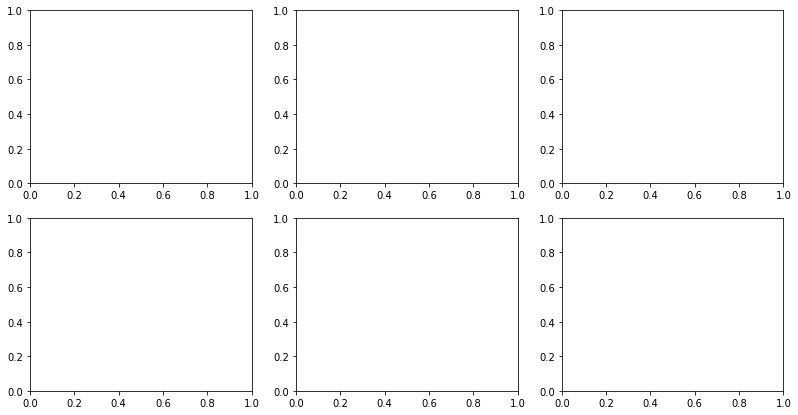

In [24]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13.5, 7))
exp2.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[11][0], clean=test_set[11][1]))
os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR', exist_ok=True)
plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR\{}.svg'.format("UDnCNN_PSNR"))

## 5. DUDnCNN
U-net like CNNs with dilated convolutions

空洞卷积(dilated convolution)代替池化来增大感受野(Receptive Field)

然而 pytorch 空洞卷积跑的贼慢，原理上看应该和普通卷积差不多快，这里有个优化的问题...

空洞卷积之前 torch.backends.cudnn.benchmark=True 之后改回 torch.backends.cudnn.benchmark=False 可以提速，详见 https://github.com/pytorch/pytorch/issues/15054.

In [25]:
class DUDnCNN(NeuralNetwork):

    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        self.mse = nn.MSELoss()
        self.features = []
        
        # compute k(max_pool) and l(max_unpool)
        k = [0]
        k.extend([i for i in range(D//2)])
        k.extend([k[-1] for _ in range(D//2, D+1)])
        l = [0 for _ in range(D//2+1)]
        l.extend([i for i in range(D+1-(D//2+1))])
        l.append(l[-1])
        
        # 空洞卷积
        holes = [2**(kl[0]-kl[1])-1 for kl in zip(k,l)]
        dilations = [i+1 for i in holes]
        
        # 卷积层
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv1d(1, C, 3, padding=dilations[0], dilation=dilations[0]))
        self.conv.extend([nn.Conv1d(C, C, 3, padding=dilations[i+1], dilation=dilations[i+1]) for i in range(D)])
        self.conv.append(nn.Conv1d(C, 1, 3, padding=dilations[-1], dilation=dilations[-1]))
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        
        # batch norm
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm1d(C, C) for _ in range(D)])
        # Batch norm layer 初始化权值
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        self.features.clear()
        D = self.D
        h = F.leaky_relu(self.conv[0](x))
        self.features.append(h)
        h_buff = []

        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            h_buff.append(h)
            self.features.append(h)
            
        for i in range(D//2 - 1, D//2 + 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            self.features.append(h)
            
        for i in range(D//2 + 1, D):
            j = i - (D//2 + 1) + 1
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1]((h + h_buff[-j]) / np.sqrt(2))
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            self.features.append(h)
            
        y = self.conv[D+1](h) + x
        return y
    
    # 损失函数使用均方误差
    def criterion(self, voutput, vtarget):
        return self.mse(voutput, vtarget)

In [26]:
lr = 1e-3
net = DUDnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp3 = Experiment(net, train_set, test_set, adam, stats_manager, batch_size=10, 
               output_dir="./checkpoints/denoising3")

Start/Continue training from epoch 200
Finish training for 200 epochs


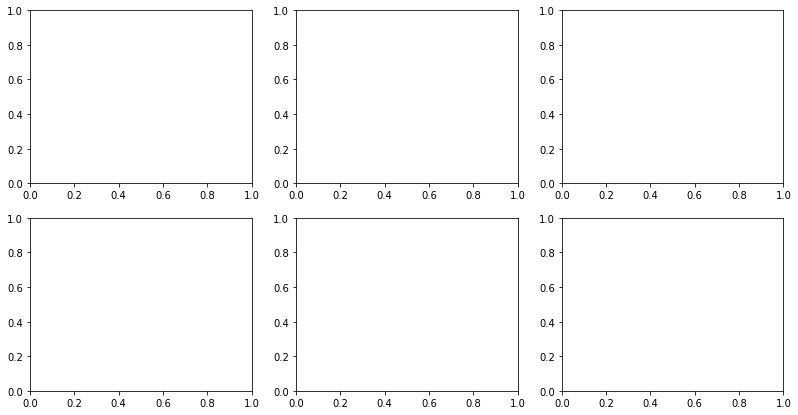

In [27]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13.5, 7))
exp3.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[11][0], clean=test_set[11][1]))
os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR', exist_ok=True)
plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR\{}.svg'.format("DUDnCNN_PSNR"))

## CDUDnCNN

In [28]:
class CBDNet(NeuralNetwork): # CBDNet+DUDnCNN融合

    def __init__(self, D, C=64):
        super(CBDNet, self).__init__()
        self.D = D
        self.mse = nn.MSELoss()
        self.features = []
        
        # compute k(max_pool) and l(max_unpool)
        k = [0]
        k.extend([i for i in range(D//2)])
        k.extend([k[-1] for _ in range(D//2, D+1)])
        l = [0 for _ in range(D//2+1)]
        l.extend([i for i in range(D+1-(D//2+1))])
        l.append(l[-1])
        
        # 空洞卷积
        holes = [2**(kl[0]-kl[1])-1 for kl in zip(k,l)]
        dilations = [i+1 for i in holes]
        
        # 卷积层
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv1d(2, C, 3, padding=dilations[0], dilation=dilations[0]))
        self.conv.extend([nn.Conv1d(C, C, 3, padding=dilations[i+1], dilation=dilations[i+1]) for i in range(D)])
        self.conv.append(nn.Conv1d(C, 1, 3, padding=dilations[-1], dilation=dilations[-1]))
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        
        # batch norm
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm1d(C, C) for _ in range(D)])
        # Batch norm layer 初始化权值
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))
        
        self.FCN_init(D, C)
 
    def FCN_init(self, D, C):
        self.FCN = nn.ModuleList()
        self.FCN.append(nn.Conv1d(1, C, 3, padding=1))
        for i in range(D-2):
            self.FCN.append(nn.Conv1d(C, C, 3, padding=1))
        self.FCN.append(nn.Conv1d(C, 1, 3, padding=1))
        
        # 初始化 
        for i in range(len(self.FCN)):
            nn.init.kaiming_normal_(self.FCN[i].weight.data, nonlinearity='leaky_relu')

    def FCN_forward(self, x):
        h = x
        for i in range(len(self.FCN)):
            h = self.FCN[i](h)
            h = F.leaky_relu(h)
        self.estimate_noisy = h
        return h            

    def forward(self, x):
        self.features.clear()
        D = self.D
        # 得出噪声估计
        h = self.FCN_forward(x)
        h = torch.cat((x, h), dim=1)
        
        h = F.leaky_relu(self.conv[0](h))
        self.features.append(h)
        h_buff = []

        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            h_buff.append(h)
            self.features.append(h)
            
        for i in range(D//2 - 1, D//2 + 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            self.features.append(h)
            
        for i in range(D//2 + 1, D):
            j = i - (D//2 + 1) + 1
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1]((h + h_buff[-j]) / np.sqrt(2))
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            self.features.append(h)
            
        y = self.conv[D+1](h) + x
        return y
    
    # 损失函数使用均方误差
    def criterion(self, voutput, vtarget):
        return self.mse(voutput, vtarget)+0.5 * torch.mean(torch.mul(torch.abs(0.3 - F.relu(vtarget - self.estimate_noisy - voutput)),torch.pow(self.estimate_noisy + voutput - vtarget, 2)))
        

        

In [29]:
lr = 1e-3
net = CBDNet(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp4 = Experiment(net, train_set, test_set, adam, stats_manager, batch_size=10, 
               output_dir="./checkpoints/denoising4")

Start/Continue training from epoch 200
Finish training for 200 epochs


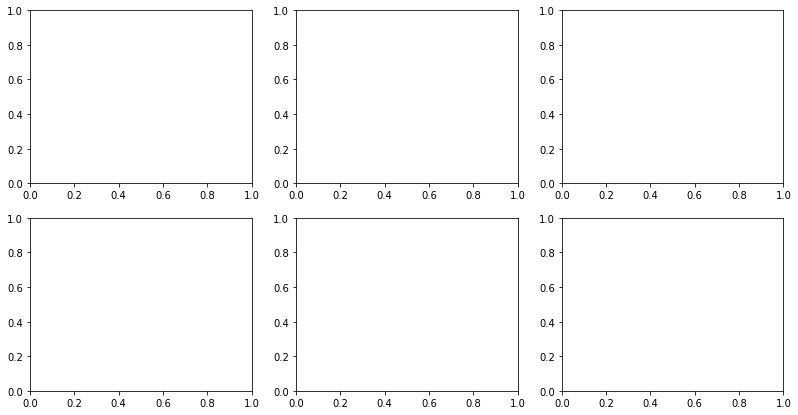

In [30]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13.5, 7))
exp4.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[11][0], clean=test_set[11][1]))
os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR', exist_ok=True)
plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR\{}.svg'.format("CDUDnCNN_PSNR"))

## DCBDNet

In [34]:
通过判别器来控制去噪的方向

NameError: name '通过判别器来控制去噪的方向' is not defined

In [ ]:
# 定义一个管理网络中参数的管理器
class StatsManager_DCBDNet(object):
    def __init__(self):
        self.init()
        
    def __repr__(self):
        return self.__class__.__name__
    
    def init(self):
        self.running_loss=0
        self.number_update=0
        self.running_psnr = 0
        self.discrimator_loss=0
        
    def accumulate(self, D_loss, loss, vinput=None, voutput=None, vtarget=None):
        self.running_loss+=loss
        self.discrimator_loss+=D_loss
        self.number_update+=1
        n = vinput.shape[0] * vinput.shape[1] * vinput.shape[2] 
        self.running_psnr += 10*torch.log10(3*n/(torch.norm(voutput-vtarget)**2))
    
    def summarize(self):
        D_loss = self.discrimator_loss/self.number_update
        loss = self.running_loss/self.number_update
        psnr = self.running_psnr / self.number_update
        return {'loss': loss, 'PSNR': psnr.cpu(), 'Discrimator_loss':D_loss}

In [ ]:
def plot(exp, fig, axes, noisy, clean, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[None].to(net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[0][2].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    axes[1][2].clear()

    mysignalshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy signal')
    
    mysignalshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised signal')
    
    mysignalshow(clean, ax=axes[0][2])
    axes[0][2].set_title('Clean signal')
    
    axes[1][0].plot([exp.history[k]['loss'] for k in range(exp.epoch)], label='training loss')
    axes[1][0].set_ylabel('Loss')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].legend()
    
    axes[1][1].plot([exp.history[k]['PSNR'] for k in range(exp.epoch)], label='training psnr')
    axes[1][1].set_ylabel('PSNR')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].legend()
    
    axes[1][2].plot([exp.history[k]['Discrimator_loss'] for k in range(exp.epoch)], label='discrimator loss')
    axes[1][2].set_ylabel('Loss')
    axes[1][2].set_xlabel('Epoch')
    axes[1][2].legend()
    
    
    plt.tight_layout()
    fig.canvas.draw()

In [35]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=2001, output_dim=1,  input_size=32):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        
        
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, 3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 64, 3, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 64, 3, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 64, 3, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 1, 3, padding=1),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid()
        )

    def forward(self, input):
        x = input 
        x = self.conv(x)
        x = x.view(-1, 2001)
        x = self.fc(x)
        return x

In [36]:
# 定义一个训练的类
class Experiment_DCBDNet(Experiment):
    def __init__(self, net, train_set, val_set, optimizer, stats_manager, 
                output_dir = None, batch_size = 16):
    
        # Define data Loaders
        # shuffle=True 在每个新的epoch里面会重新打乱形成新的batch
        # drop_last=True 当样本数量被分割成多个batch的时候，如果还有多的数据（少于batchsize），那么这些样本会被扔掉
        # pin_memory=True 让每个batch形成的张量能更快进入到cuda中
        self.train_loader = td.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
        self.val_loader = td.DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
        self.net = net
        self.stats_manager = stats_manager
        self.batch_size = batch_size
        self.D = Discriminator()
        self.D_optimizer = torch.optim.Adam(self.D.parameters())
        self.D = self.D.to(self.net.device)
        
        
        # Define history
        self.history = []

        # Define checkpoint paths
        if output_dir is None:
            output_dir = "Denoising_{}".format(time.time())
        os.makedirs(output_dir, exist_ok=True)
        checkpoint_path = os.path.join(output_dir, "checkpoint.pth.tar")
        config_path = os.path.join(output_dir, "config.txt")

        # 将全局变量全部转化成字典形式
        maps = {k:v for k, v in locals().items() if k != 'self'}
        self.__dict__.update(maps)

        # 存储checkpoint或者继续加载模型
        if os.path.isfile(self.config_path):
            with open(config_path, 'r') as f:
                if f.read()[:-1] != repr(self):
                    raise ValueError(
                            "Cannot create this experiment: "
                            "I found a checkpoint conflicting with the current setting.")
                else:
                    self.load()
        else:
            self.save()
    
    # 获取当前的epoch
    @property
    def epoch(self):
        return len(self.history)
    
    # 获取当前的网络的配置，用字典返回
    def setting(self):
        return {'Net': self.net,
                'TrainSet': self.train_set,
                'ValSet': self.val_set,
                'Optimizer': self.optimizer,
                'StatsManager': self.stats_manager,
                'BatchSize': self.batch_size}   
    
    # 重写repr内置函数，用字符串的形式返回当前网络的配置
    def __repr__(self):
        string = ''
        for k, v in self.setting().items():
            string += '{} : {} \n'.format(k, v)
        return string
    
    # 返回当前网络训练的状态，用字典的形式
    def state_dict(self):
        return {'Net': self.net.state_dict(),
                'Optimizer': self.optimizer.state_dict(),
                'History': self.history}
        
        
    # 将网络模型(重写的repr返回值)保存在config_path中，同时将网络的state_dict（参数什么的）保存到checkpoint_path
    def save(self):
        torch.save(self.state_dict(), self.checkpoint_path)
        with open(self.config_path, 'w') as f:
            print(self, file=f)
    
    
    # 读取检查点，进行装载
    def load(self):
        checkpoint = torch.load(self.checkpoint_path, map_location=self.net.device)
        self.net.load_state_dict(checkpoint['Net'])
        self.optimizer.load_state_dict(checkpoint['Optimizer'])
        self.history = checkpoint['History']
#         for state in self.optimizer.state.values():
#             for k, v in state.items():
#                 if isinstance(v, torch.Tensor):
#                     state[k] = v.to(self.net.device)
        del checkpoint
        
        
    def run(self, num_epochs, plot=None):
        # 设置网络的状态是train状态(mode=True)，而不是eval状态(mode=False)，这只对某些特定的模块有作用
        self.net.train(mode=True)
        self.stats_manager.init()
        start_epoch = self.epoch
        print("Start/Continue training from epoch {}".format(start_epoch))
        
#         if(plot is not None):
#             plot(self)
        
        for epoch in range(start_epoch, num_epochs):
            s = time.time()
            # 每一个新的epoch都要重新计算loss
            self.stats_manager.init()
            self.D.train()
            for iter, (vinput, vtarget) in enumerate(self.train_loader):
                
                # 将变量挂载到CPU或者GPU
                vinput = vinput.to(self.net.device)
                vtarget = vtarget.to(self.net.device)
                
                # -----------------训练判别器--------------------
                self.D_optimizer.zero_grad()   
                D_real = self.D(vtarget)
                D_real_loss = -torch.mean(D_real)
                
                fake_signal = self.net.forward(vinput)
                D_fake = self.D(fake_signal)
                D_fake_loss = torch.mean(D_fake)
                
                D_loss = D_fake_loss +  D_real_loss               
                D_loss.backward()
                self.D_optimizer.step()
                # print(D_loss)
                # -----------------训练判别器--------------------
                # 每训练50次判别器,就训练一次生成器
#                 if(iter%50 != 0):
#                     continue
                
                # 将优化器里面的梯度全部清空
                self.optimizer.zero_grad()
                # 开始前向传播
                voutput = self.net.forward(vinput)
                # 计算loss
                D_voutput = self.D(voutput)
                D_voutput_loss = self.net.criterion(voutput,vtarget)-0.1*torch.mean(D_voutput)
                loss = D_voutput_loss
                # 根据loss计算梯度
                loss.backward()
                # 利用优化器进行单次权值w更新
                self.optimizer.step()
                
                # loss.item()是将loss这个零维张量转化成浮点数
                with torch.no_grad():
                    self.stats_manager.accumulate(D_loss.item(), loss.item(), vinput, voutput, vtarget)
            # 将每次epoch中的loss加入到history中    
            self.history.append(self.stats_manager.summarize())
            # 输出每一轮的loss
            print('Epoch {}  Time:{}  Loss:{}'.format(self.epoch, time.time()-s, self.stats_manager.summarize()))
            # 每一个epoch后都对模型和训练过程进行保存
            self.save()
            if plot is not None:
                plot(self)
                
        print("Finish training for {} epochs".format(num_epochs))
            
    
    def evaluate(self):
        self.stats_manager.init()
        # 指定是eval模式
        self.net.eval()
        with torch.no_grad():
            for vinput, vtarget in self.val_loader:
                vinput = vinput.to(self.net.device)
                vtarget = vtarget.to(self.net.device)
                voutput = self.net.forward(vinput)
                loss = self.net.criterion(voutput, vtarget) + 0.5*D_voutput_loss
                self.stats_manager.accumulate(loss.item(), vinput, voutput, vtarget)
        return self.stats_manager.summarize()

In [ ]:
lr = 1e-3
net = CBDNet(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = StatsManager_DCBDNet()
exp5 = Experiment_DCBDNet(net, train_set, test_set, adam, stats_manager, batch_size=10, 
               output_dir="./checkpoints/denoising5")

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13.5, 7))
exp5.run(num_epochs=2000, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[11][0], clean=test_set[11][1]))
os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR', exist_ok=True)
plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR\{}.svg'.format("DCBDNet_PSNR"))

## 6. 比较`DnCNN` `UDnCNN` `DUDnCNN`

看下三个网络的loss和PSNR

In [31]:
# DnCNN
exp1.evaluate()

{'loss': 0.004736413567514862, 'PSNR': tensor(28.0663)}

In [32]:
# UDnCNN
exp2.evaluate()

{'loss': 0.0018476889138886083, 'PSNR': tensor(32.1782)}

In [33]:
# DUDnCNN
exp3.evaluate()

{'loss': 0.001259246732252793, 'PSNR': tensor(33.8889)}

In [34]:
# CBDNet
exp4.evaluate()

{'loss': 0.001302258851514157, 'PSNR': tensor(34.1329)}

看下三个网络处理的效果

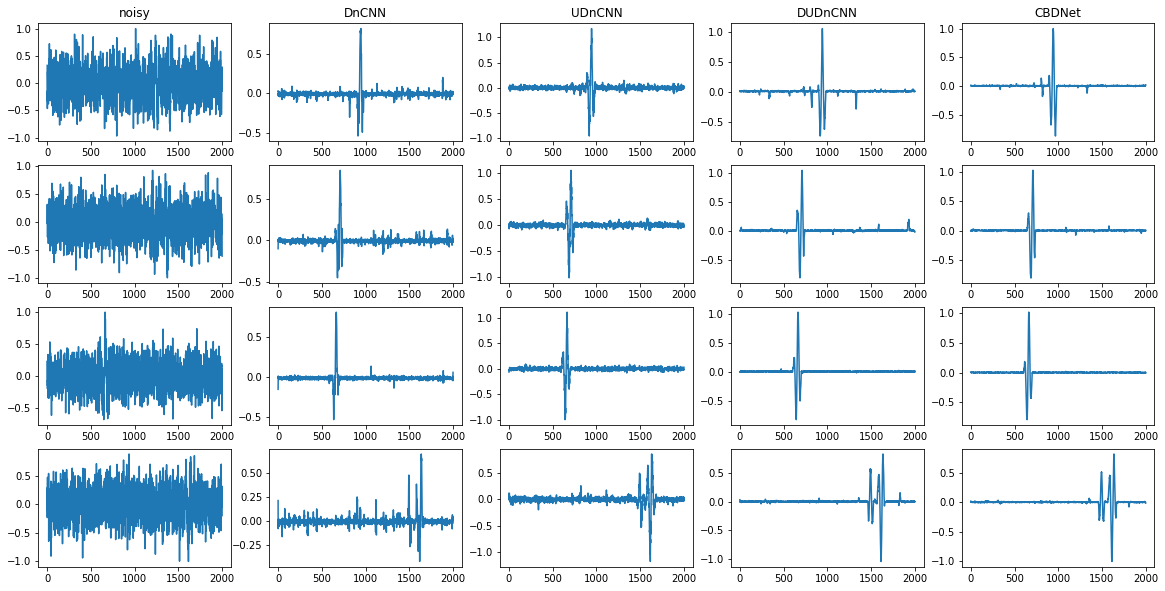

In [35]:
num = 2 
signal = []
nets = [exp1.net, exp2.net, exp3.net, exp4.net]
titles = ['noisy', 'DnCNN', 'UDnCNN', 'DUDnCNN', 'CBDNet']

fig, axes = plt.subplots(ncols=5, nrows=num*2, figsize=(20,10))

for i in range(num):
    mysignalshow(train_set[7*i+7][0], ax=axes[i][0])
    x, _ = test_set[7*i+7]
    x = x.unsqueeze(0).to(device)
    signal.append(x)
    
for i in range(1,num+1):
    mysignalshow(train_set[200*i+7][0], ax=axes[i+num-1][0])
    x, _ = train_set[200*i+7]
    x = x.unsqueeze(0).to(device)
    signal.append(x)  
    
for i in range(num*2):
    for j in range(len(nets)):
        model = nets[j].to(device)
        model.eval()
        with torch.no_grad():
            y = model.forward(signal[i])
        mysignalshow(y[0], ax=axes[i][j+1])
for i in range(1):
    for j in range(len(titles)):
        axes[i][j].set_title(f'{titles[j]}')

## 7. 提取特征图

In [36]:
# 设计一个我的画图
def MyFeatureShow(feature, ax = plt):
    feature = feature.to('cpu').numpy()
#     将特征输出的通道全部相加
    feature = np.sum(feature, axis = 1)[0]
#     feature = feature[0, 1, :]
    ax.plot(feature)

In [37]:
def MyFeaturesShow(model, name):
    fig, axes = plt.subplots(2, 3, figsize = (20, 10))
    
    MyFeatureShow(model.features[0], ax=axes[0][0])
    axes[0][0].set_title('{}_conv1'.format(name))
    
    MyFeatureShow(model.features[1], ax=axes[0][1])
    axes[0][1].set_title('{}_conv2'.format(name))
    
    MyFeatureShow(model.features[2], ax=axes[0][2])
    axes[0][2].set_title('{}_conv3'.format(name))
    
    MyFeatureShow(model.features[3], ax=axes[1][0])
    axes[1][0].set_title('{}_conv4'.format(name))
    
    MyFeatureShow(model.features[4], ax=axes[1][1])
    axes[1][1].set_title('{}_conv5'.format(name))
    
    MyFeatureShow(model.features[5], ax=axes[1][2])
    axes[1][2].set_title('{}_conv6'.format(name))
    
    plt.tight_layout()
    
    os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\特征集', exist_ok=True)
    plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\特征集\{}_features.svg'.format(name))

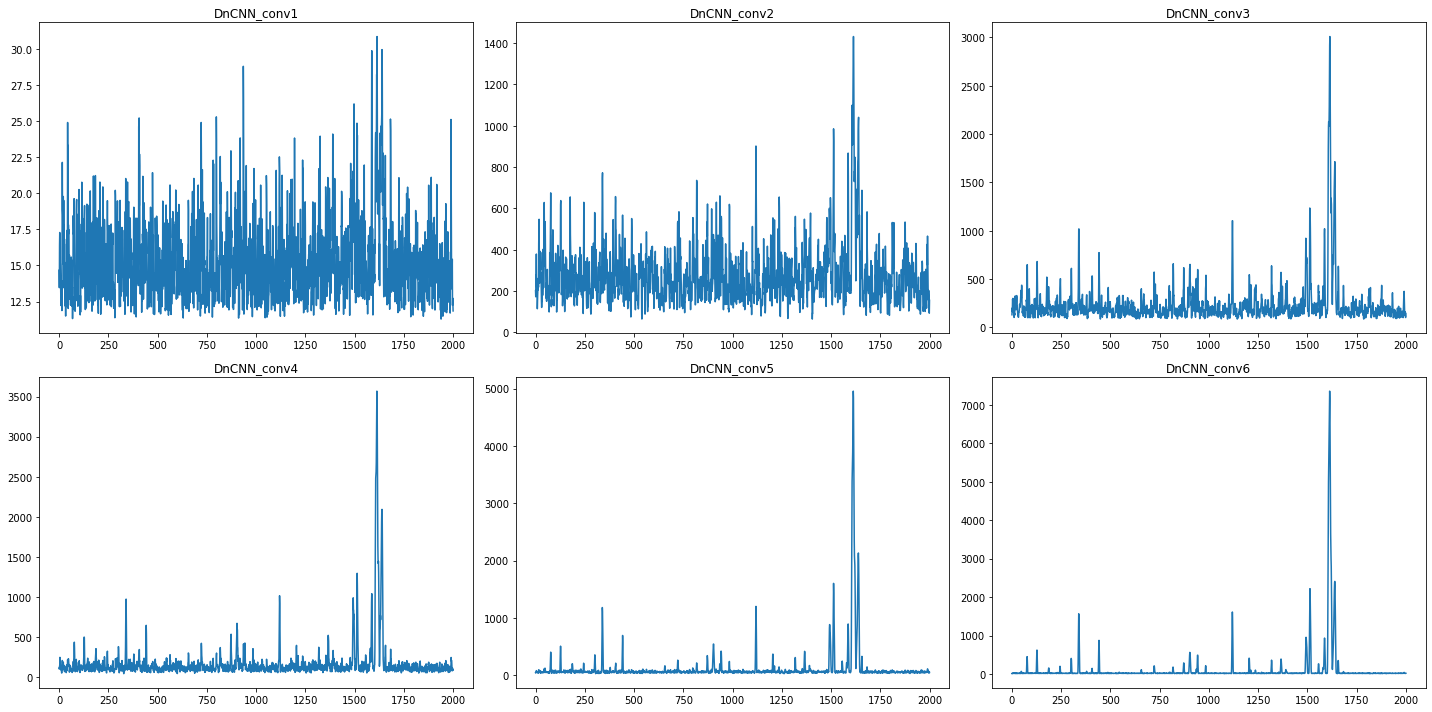

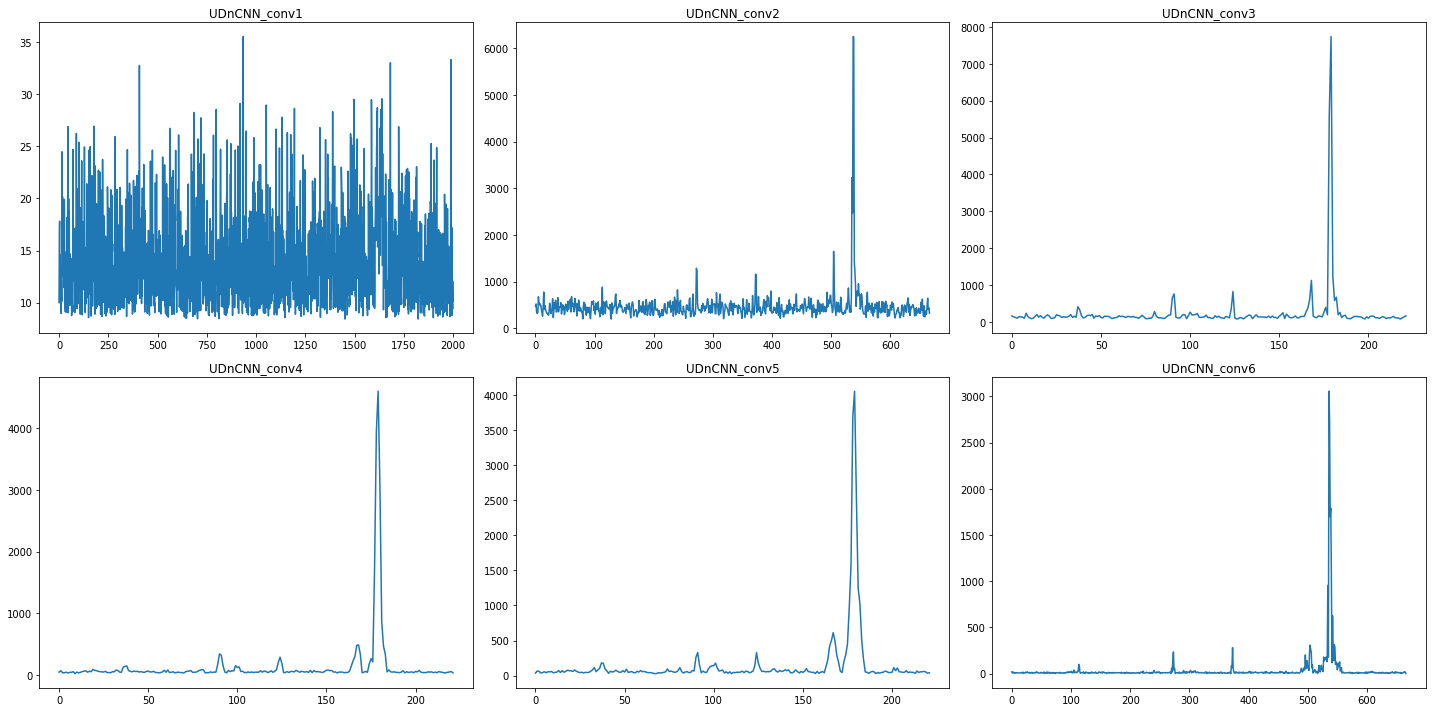

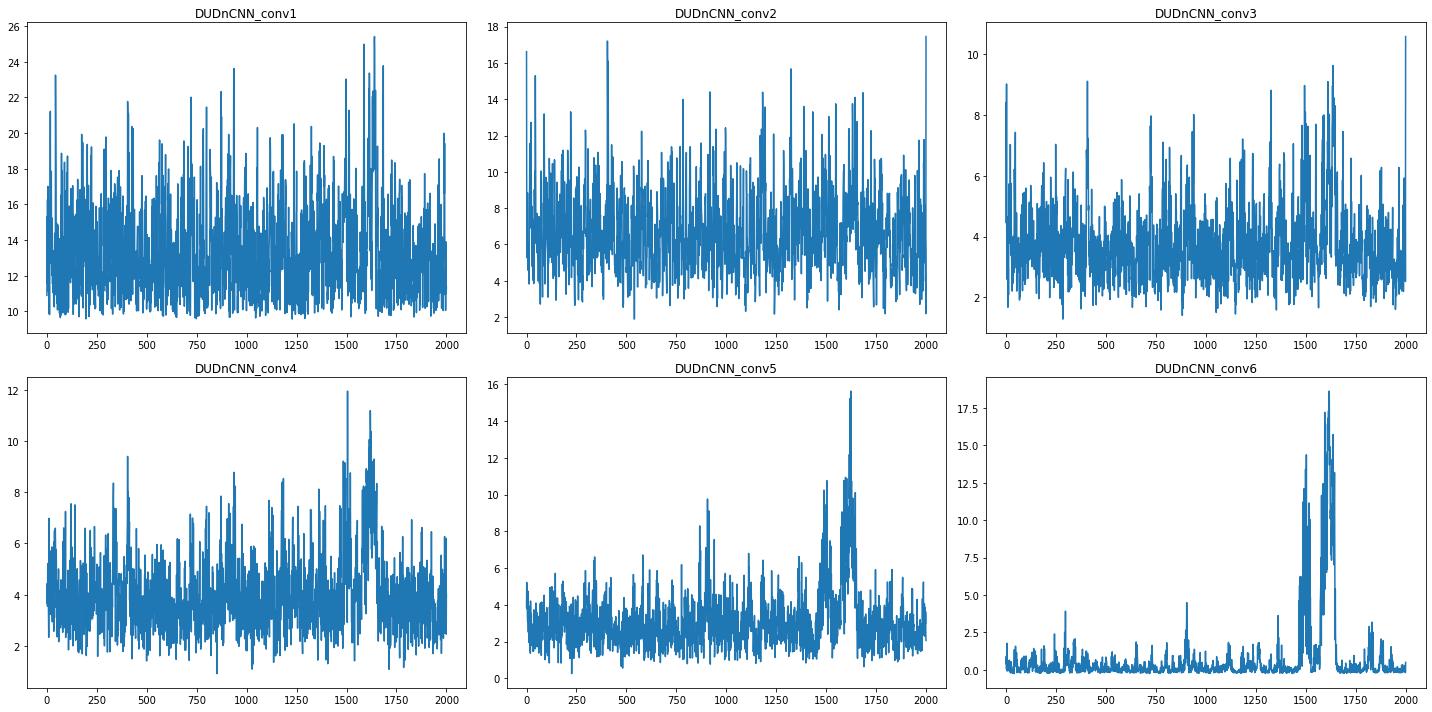

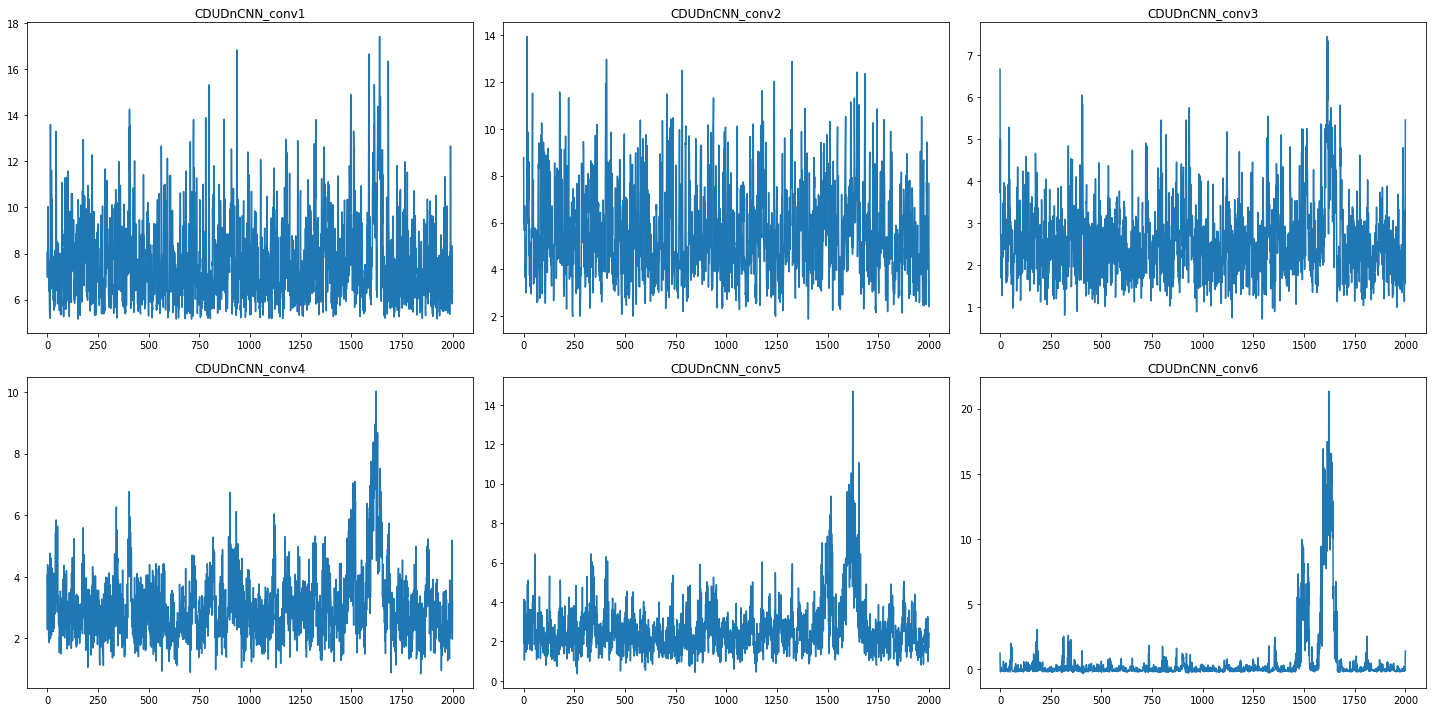

In [38]:
MyFeaturesShow(exp1.net, "DnCNN")
MyFeaturesShow(exp2.net, "UDnCNN")
MyFeaturesShow(exp3.net, "DUDnCNN")
MyFeaturesShow(exp4.net, "CDUDnCNN")

## 8.保存结果集

#### 杂项

In [39]:
def mysignalshow(signal, ax = plt):
    # 将张量转化成数据
    plt.xlim(0, 2001)
    signal = data.max_abs_scaler.inverse_transform(signal.to('cpu').numpy())[0]
    ax.plot(np.array(signal))

In [40]:
nets = [exp1.net, exp2.net, exp3.net, exp4.net]
titles = ['noisy', 'DnCNN', 'UDnCNN', 'DUDnCNN', 'CBDNet']
# for i in range(len(test_set)):
#     noisy, clean = test_set[i]
#     # 信号增加一个维度， mysignal的输入是batch*2001
#     noisy = noisy.unsqueeze(0).to(device)
#     clean = clean.unsqueeze(0).to(device)
#     fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20,10))
#     # 画noisy
#     mysignalshow(noisy[0], axes[0][0])
#     axes[0][0].set_title('{}_{}'.format(titles[0], i))
# #     画clean
# #     mysignalshow(clean[0], axes[0][1])
# #     axes[0][1].set_title('{}_{}'.format(titles[1], i))
    
#     for j in range(3):
#         model = nets[j]
#         model.eval()
#         with torch.no_grad():
#             y = model.forward(noisy)
#         if(j == 0):
#             mysignalshow(y[0], axes[0][1])
#             axes[0][1].set_title('{}_{}'.format(titles[j+1], i))
#         elif(j == 1):
#             mysignalshow(y[0], axes[1][0])
#             axes[1][0].set_title('{}_{}'.format(titles[j+1], i))
#         else:
#             mysignalshow(y[0], axes[1][1])
#             axes[1][1].set_title('{}_{}'.format(titles[j+1], i))
    
    
#     os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\输出集', exist_ok=True)
#     plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\输出集\{}.svg'.format(i))
    
    


### 画一个剖面

In [41]:
def mysignalshow_10(signal, i, ax = plt):
    # 将张量转化成数据
    signal = signal.to('cpu').numpy()[0]
    signal = [item+4*i for item in signal]
    ax.plot(np.array(signal),color="black")

In [42]:
nets = [exp1.net, exp2.net, exp3.net, exp4.net]
titles = ["DnCNN", "UDnCNN", "DUDnCNN", "CDUDnCNN", "Clean", "Noisy"]
for j in range(6):
    fig = plt.figure(figsize = (30,20))
    ax  = fig.add_subplot(1,1,1)
    for i in range(10):
        noisy, clean = test_set[i]
        noisy = noisy.unsqueeze(0).to(device)
        clean = clean.unsqueeze(0).to(device)
        
        if(titles[j] == "Clean"):
            mysignalshow_10(clean[0], i, ax)
        elif(titles[j] == "Noisy"):
            mysignalshow_10(noisy[0], i, ax)
        else:  
            model = nets[j]
            model.eval()
            with torch.no_grad():
                y = model.forward(noisy)
            mysignalshow_10(y[0], i, ax)
       
        
    ax.set_title('{}'.format(titles[j]))
    os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\剖面', exist_ok=True)
    plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\剖面\{}.svg'.format(titles[j]))
    plt.close(fig) 

### 画一个干净、noisy、DnCNN、CBDNet的结果图（4*1）

In [43]:
# for i in range(len(test_set)):
#     noisy, clean = test_set[i]
#     noisy = noisy.unsqueeze(0).to(device)
#     clean = clean.unsqueeze(0).to(device)
#     fig = plt.figure(figsize = (30,20))
#     ax1  = fig.add_subplot(4,1,1)
#     ax2  = fig.add_subplot(4,1,2)
#     ax3  = fig.add_subplot(4,1,3)
#     ax4  = fig.add_subplot(4,1,4)
# #     fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(20,10))
#     # 画一个clean
#     mysignalshow(clean[0], ax1)
#     ax1.set_title('{}'.format("clean"))
    
#     # 画一个noisy
#     mysignalshow(noisy[0], ax2)
#     ax2.set_title('{}'.format("noisy"))
    
#     # 画一个DUDnCNN
#     model = exp3.net
#     model.eval()
#     with torch.no_grad():
#         y = model.forward(noisy)
#     mysignalshow(y[0], ax3)
#     ax3.set_title('{}'.format("DUDnCNN"))
    
#     # 画一个CBDNet
#     model = exp4.net
#     model.eval()
#     with torch.no_grad():
#         y = model.forward(noisy)
#     mysignalshow(y[0], ax4)
#     ax4.set_title('{}'.format("CBDNet"))
    
    
#     os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\论文', exist_ok=True)
#     plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\论文\{}.svg'.format(i))
#     plt.close(fig) 

## 9.测试训练

### 使用真实信号给网络进行测试

读取真实信号数据

In [44]:
path = r"C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\dataset"
filenames = []
# 读取dataset文件夹下的干净信号txt
filenames = os.listdir(os.path.join(path,"clean_signal","真实信号txt"))
filenames.sort(key = lambda x: int(x[0:-4]))
real_signal = []
for filename in filenames:
    real_signal.append(np.loadtxt(os.path.join(path,"clean_signal","真实信号txt", filename)))

In [52]:
def put1dToModelAndPlot(model, real_signal, ax ,num = i,  saveOriginSignal = 0):
    x = maxabs_scale(real_signal, axis=0)
    y = np.array([])
    if(saveOriginSignal == 1):
        y = x
        y = [item+4*i for item in y]
        ax.plot(y)
        return 
    for j in range(3):
        if(j == 0):
            x1 = x[:2001]
        elif(j == 1):
            x1 = x[2001:4002]
        else:
            x1 = x[4000:6001]
        x1 = torch.Tensor(x1).to(device)   
        x1 = x1.unsqueeze(0)
        x1 = x1.unsqueeze(0)
        y1 = model.forward(x1)
        y1 = y1.to('cpu')[0][0]
        y1 = y1.detach().numpy()
        y1 = np.array(y1)
        y = np.concatenate((y, y1))
        
    y = [item+4*i for item in y]    
    ax.plot(y,color="black")

In [53]:
path = r"C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\真实信号结果"

# 画出clean 信号 
fig1 = plt.figure(figsize = (30,20))
ax1 = fig1.add_subplot(1,1,1)
for i in range(10):
    item = real_signal[i]
    put1dToModelAndPlot(exp1.net, item, ax1, i, 1)
fig1.suptitle("Clean", fontsize = 30)
plt.savefig(os.path.join(path, "Clean.svg"))
plt.close()

# 画出DncNN 信号 
fig1 = plt.figure(figsize = (30,20))
ax1 = fig1.add_subplot(1,1,1)
for i in range(10):
    item = real_signal[i]
    put1dToModelAndPlot(exp1.net, item, ax1, i)
fig1.suptitle("DnCNN", fontsize = 30)
plt.savefig(os.path.join(path, "DnCNN.svg"))
plt.close()


# UDnCNN 信号 
fig1 = plt.figure(figsize = (30,20))
ax1 = fig1.add_subplot(1,1,1)
for i in range(10):
    item = real_signal[i]
    put1dToModelAndPlot(exp2.net, item, ax1, i)
fig1.suptitle("UDnCNN", fontsize = 30)
plt.savefig(os.path.join(path, "UDnCNN.svg"))
plt.close()


# DUDnCNN 信号 
fig1 = plt.figure(figsize = (30,20))
ax1 = fig1.add_subplot(1,1,1)
for i in range(10):
    item = real_signal[i]
    put1dToModelAndPlot(exp3.net, item, ax1, i)
fig1.suptitle("DUDnCNN", fontsize = 30)
plt.savefig(os.path.join(path, "DUDnCNN.svg"))
plt.close()


# CDUDnCNN 信号 
fig1 = plt.figure(figsize = (30,20))
ax1 = fig1.add_subplot(1,1,1)
for i in range(10):
    item = real_signal[i]
    put1dToModelAndPlot(exp4.net, item, ax1, i)
fig1.suptitle("CDUDnCNN", fontsize = 30)
plt.savefig(os.path.join(path, "CDUDnCNN.svg"))
plt.close()

